In [1]:
'''This notebook simulates various spectrometers that PivotBio may purchase
It uses data from Andrew Leakey's 2017 paper.

Link to working doc
https://docs.google.com/document/d/1UIeeH1bvLLrNnaSBwEMORUi43D5cDK_Wlhp7YhqQNoY/edit#heading=h.6tfl63cme32b

pandas how-to: 
https://www.shanelynn.ie/using-pandas-dataframe-creating-editing-viewing-data-in-python/
'''

#1 import libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

 
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.externals import joblib 
from sklearn.cross_decomposition import PLSCanonical, PLSRegression, CCA


def vip(model):
  t = model.x_scores_
  w = model.x_weights_
  q = model.y_loadings_
  p, h = w.shape
  vips = np.zeros((p,))
  s = np.diag(t.T @ t @ q.T @ q).reshape(h, -1)
  total_s = np.sum(s)
  for i in range(p):
      weight = np.array([ (w[i,j] / np.linalg.norm(w[:,j]))**2 for j in range(h) ])
      vips[i] = np.sqrt(p*(s.T @ weight)/total_s)
  return vips


In [26]:
from sklearn import datasets
from sklearn import svm
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline

def plsr_num_components(x, y, max_n=20):
    scores = []
    rows, cols = x.shape
    if cols <= max_n:
        max_n = cols - 1
    n_range = range(2, max_n)
    best_n = 0 
    for i in n_range:
        pls2 = make_pipeline(preprocessing.StandardScaler(), PLSRegression(n_components=i))
        score = cross_val_score(pls2, x, y, cv=5, scoring = 'neg_mean_squared_error')
        scores.append(np.mean(score))
        if len(scores)>2 and best_n==0:
            if scores[-2] > scores[-1]:
                best_n = i-1
    if best_n == 0:
        best_n = max_n
    return(best_n)

def fit_plsr(x, y, n_components=10, debug=False, max_n=20):
    x_train, x_test, y_train, y_test = train_test_split(x, y, 
                                                        test_size=0.2, 
                                                        random_state=23)  
    n_components = plsr_num_components(x_train,y_train, max_n=max_n)
    print("number of components is %d" % (n_components))
  
    pls2 = PLSRegression(n_components)
    pls2.fit(x_train, y_train)
     
    if debug:
        print('\nTraining Set')
        print('R2 for all components (): %g' %round(r2_score(y_train,pls2.predict(x_train)),3)) #Calcuted from PLSRegression's 'predict' function.
        print('Mean absolute error is (): %g' %round(mean_absolute_error(y_train,pls2.predict(x_train)),3))
        #plt.plot(vip(pls2))

        print('\nTest set')
        print('R2 for all components (): %g' %round(r2_score(y_test,pls2.predict(x_test)),3)) #Calcuted from PLSRegression's 'predict' function.
        print('Mean absolute error is (): %g' %round(mean_absolute_error(y_test,pls2.predict(x_test)),3))

        plt.plot(pls2.predict(x_test),y_test,'ro')
        plt.plot(pls2.predict(x_train),y_train,'bo')
     
    r2_train = round(r2_score(y_train, pls2.predict(x_train)),3)
    r2_test = round(r2_score(y_test, pls2.predict(x_test)),3)
    mae_train = round(mean_absolute_error(y_train, pls2.predict(x_train)),3)
    mae_test = round(mean_absolute_error(y_test, pls2.predict(x_test)),3)
    
    return [pls2, x_train, x_test, y_train, y_test], r2_train, r2_test, mae_train, mae_test



In [24]:
#2 Load Data
data_path = "/home/heydocbrown/git/spectroscopy/Illinois_chl_n_spectral_data.csv"
data_path2 = "/home/heydocbrown/git/spectroscopy/Illinois_spectral_data.csv"
data_n_chl = pd.read_csv(data_path)
data_all = pd.read_csv(data_path2)

#3 Clean data
rename_dict = {"Measured_Chl": "measured_chl",
                   "PLSR_Chl":"plsr_chl",
                   "measured_percentN": "measured_nitrogen",
                   "PLSR_N content":"plsr_nitrogen"}
data_all.rename(columns = rename_dict, inplace=True)
data_all.rename(columns=lambda x: x.lower().replace(' ', '_'), inplace=True)
data_n_chl.rename(columns = rename_dict, inplace=True)
data_n_chl.rename(columns=lambda x: x.lower().replace(' ', '_'), inplace=True)

#4 split data 
spectrum_all = data_all.iloc[:, 7:1908]

spectrum_n_chl = data_n_chl.iloc[:, 7:1908] #500 to 2400
nitrogen = data_n_chl.measured_nitrogen
chlorophyll = data_n_chl.measured_chl
nitrogen_all = data_all.measured_nitrogen
chlorophyll_all = data_all.measured_chl





In [27]:
#Spectrometer Model
# 500nm to 2400nm  - full spectrum
# 1500nm to 2400nm - nitrogen spectrum
# 500nm to 1000nm - uv-vis
# 1000nm to 1700nm - nir
# 500nm to 1700nm - vnir
# 1000nm to 2400nm - nir + SWIR
# than all of these with binning at 5nm, 10nm, 25nm, 50nm

#LED model
# 850nm + 660nm
# 660nm + 730n,
# see document for more

#indexes for the pandas data frame
index_500nm = 7
index_1000nm = 507
index_2400nm = 1907
index_1500nm = 1007
index_1700nm = 1207


spectrum_500to2400 = [data_n_chl.iloc[:, index_500nm:index_2400nm+1], "500nm to 2400nm"]
spectrum_1500to2400 = [data_n_chl.iloc[:, index_1500nm:index_2400nm+1], "1500nm to 2400nm"]
spectrum_500to1000 = [data_n_chl.iloc[:, index_500nm:index_1000nm+1], "500nm to 1000nm"]
spectrum_1000to1700 = [data_n_chl.iloc[:, index_1000nm:index_1700nm+1], "1000nm to 1700nm"]
spectrum_500to_1700 = [data_n_chl.iloc[:, index_500nm:index_1700nm+1], "500nm to 1700nm"]
spectrum_1000to2400 = [data_n_chl.iloc[:, index_1000nm:index_2400nm+1], "1000nm to 2400nm"]

spectra = [spectrum_500to2400, spectrum_1500to2400, spectrum_500to_1700, spectrum_1000to2400, spectrum_1000to1700, spectrum_500to1000]

# 5 Analyze

for x in spectra:
    model_n, r2_train_n, r2_test_n, mae_train_n, mae_test_n = fit_plsr(x[0], nitrogen)
    mae_n = round(mae_train_n*.8 + mae_test_n*.2, 3)
    print(x[1], " nitrogen, r2: ", r2_train_n, " , ", r2_test_n, " mae: ", mae_n, " range: ", max(nitrogen)-min(nitrogen), "\n")

for x in spectra:
    model_chl, r2_train_chl, r2_test_chl, mae_train_chl, mae_test_chl = fit_plsr(x[0], chlorophyll)
    mae_chl = round(mae_train_chl*.8 + mae_test_chl*.2, 3)
    print(x[1], " chlorophyll, r2:", r2_train_chl, "  , ", r2_test_chl, " mae: ", mae_chl, "range: ", max(chlorophyll)-min(chlorophyll), "\n")

        

number of components is 10
500nm to 2400nm  nitrogen, r2:  0.969  ,  0.954  mae:  0.194  range:  4.24 

number of components is 10
1500nm to 2400nm  nitrogen, r2:  0.973  ,  0.952  mae:  0.183  range:  4.24 

number of components is 14
500nm to 1700nm  nitrogen, r2:  0.969  ,  0.94  mae:  0.191  range:  4.24 

number of components is 13
1000nm to 2400nm  nitrogen, r2:  0.98  ,  0.965  mae:  0.159  range:  4.24 

number of components is 11
1000nm to 1700nm  nitrogen, r2:  0.96  ,  0.936  mae:  0.216  range:  4.24 

number of components is 9
500nm to 1000nm  nitrogen, r2:  0.938  ,  0.895  mae:  0.26  range:  4.24 

number of components is 10
500nm to 2400nm  chlorophyll, r2: 0.871   ,  0.894  mae:  2.711 range:  42.651196750000004 

number of components is 12
1500nm to 2400nm  chlorophyll, r2: 0.835   ,  0.829  mae:  2.996 range:  42.651196750000004 

number of components is 7
500nm to 1700nm  chlorophyll, r2: 0.855   ,  0.919  mae:  2.692 range:  42.651196750000004 

number of componen




number of components is 12
500nm to 2400nm  nitrogen, r2:  0.964  ,  0.947  mae:  0.206  range:  4.24 

number of components is 11
1500nm to 2400nm  nitrogen, r2:  0.967  ,  0.967  mae:  0.195  range:  4.24 

number of components is 10
500nm to 1700nm  nitrogen, r2:  0.938  ,  0.899  mae:  0.265  range:  4.24 

number of components is 12
1000nm to 2400nm  nitrogen, r2:  0.969  ,  0.967  mae:  0.183  range:  4.24 

number of components is 9
1000nm to 1700nm  nitrogen, r2:  0.912  ,  0.89  mae:  0.311  range:  4.24 

number of components is 6
500nm to 1000nm  nitrogen, r2:  0.877  ,  0.859  mae:  0.37  range:  4.24 



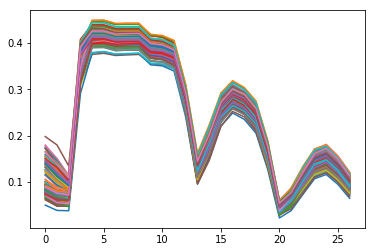

In [38]:
def reduce_and_average(array, interval):
    rows, cols = array.shape
    groups = cols // interval
    new_array = np.zeros((rows, groups))
    for x in range(groups):
        index0 = x*interval
        index1 = index0 + interval
        new_array[:, x] = np.sum(array[:, index0:index1], axis=1)/interval
    return new_array        

#for x in spectra:
#    model_n, r2_train_n, r2_test_n, mae_train_n, mae_test_n = fit_plsr(x[0], nitrogen)
#    mae_n = round(mae_train_n*.8 + mae_test_n*.2, 3)
#    print(x[1], " nitrogen, r2: ", r2_train_n, " , ", r2_test_n, " mae: ", mae_n, " range: ", max(nitrogen)-min(nitrogen), "\n")

interval = 70
reduced_spectra = reduce_and_average(spectrum_500to2400[0].values,interval)
plt.plot(np.transpose(reduced_spectra))

 
print("\n\n")
for x in spectra:
    y = reduce_and_average(x[0].values, interval)
    model_n, r2_train_n, r2_test_n, mae_train_n, mae_test_n = fit_plsr(y, nitrogen, max_n=12)
    mae_n = round(mae_train_n*.8 + mae_test_n*.2, 3)
    print(x[1], " nitrogen, r2: ", r2_train_n, " , ", r2_test_n, " mae: ", mae_n, " range: ", max(nitrogen)-min(nitrogen), "\n")


In [184]:
bin_size = 25

for x in spectra:
    y = x[0].values.reshape(-1, 25).mean(axis=1)
---------------------------------------------------------------------------
AttributeError                            Traceback (most recent call last)
<ipython-input-177-c3ebefffae75> in <module>()
      2 
      3 for x in spectra:
    model_n, r2_train_n, r2_test_n, mae_train_n, mae_test_n = fit_plsr(y, nitrogen)
    print(x[1], " nitrogen, r2: ", r2_train_n, " , ", r2_test_n, " mae: ", mae_test_n, " range: ", max(nitrogen)-min(nitrogen))

for x in spectra:
    model_chl, r2_train_chl, r2_test_chl, mae_train_chl, mae_test_chl = fit_plsr(x[0], chlorophyll)
    print(x[1], " chlorophyll, r2:", r2_train_chl, "  , ", r2_test_chl, " mae: ", mae_test_chl, "range: ", max(chlorophyll)-min(chlorophyll))




ValueError: cannot reshape array of size 317467 into shape (25)

In [18]:
data_all.describe()

,Unnamed: 0,Growing Season,Measured_Chl,PLSR_Chl,Wave_500,Wave_501,Wave_502,Wave_503,Wave_504,Wave_505,...,Wave_2400,Growing season,measured_percentN,PLSR_N content,measured_SLA,PLSR_Pred_SLA,measured_Vmax,PLSR_Pred_Vmax,Measured_Sucrose,PLSR_Sucrose
count,340.000000,304.000000,268.000000,268.000000,304.000000,304.000000,304.000000,304.000000,304.000000,304.000000,...,340.000000,203.0,203.000000,203.000000,182.000000,182.000000,214.000000,214.000000,61.000000,61.000000
mean,170.500000,2014.256579,25.374844,25.374844,0.061267,0.061758,0.062297,0.062892,0.063539,0.064262,...,0.079202,2014.0,3.494433,3.494433,25.240622,25.240622,36.291571,36.291571,4.694366,4.694366
std,98.293777,0.437465,9.232919,8.609651,0.010969,0.011203,0.011455,0.011746,0.012082,0.012416,...,0.011172,0.0,1.207812,1.184894,2.679217,2.434231,11.908391,9.905103,1.832097,1.564596
min,1.000000,2014.000000,6.728803,8.078279,0.031491,0.031776,0.031936,0.032069,0.032296,0.032794,...,0.046716,2014.0,1.150000,0.916590,19.455429,18.215422,7.320000,1.025103,1.304040,1.808899
25%,85.750000,2014.000000,18.232500,18.592691,0.053236,0.053440,0.053782,0.054252,0.054651,0.055208,...,0.070732,2014.0,2.575000,2.457179,23.322075,23.745164,28.630000,31.779692,3.124979,3.388291
50%,170.500000,2014.000000,25.285301,25.618137,0.058703,0.059083,0.059540,0.060104,0.060575,0.061185,...,0.079181,2014.0,3.940000,3.934796,24.906484,25.429042,37.015000,38.115645,4.560539,4.479817
75%,255.250000,2015.000000,30.918006,32.450673,0.069296,0.070049,0.070558,0.071367,0.071862,0.072702,...,0.088459,2014.0,4.445000,4.429228,27.037526,26.901836,44.630025,43.419943,5.811486,5.833435
max,340.000000,2015.000000,49.380000,43.507651,0.094813,0.096717,0.098813,0.101144,0.103815,0.106572,...,0.109707,2014.0,5.390000,5.247462,32.425714,30.574179,62.340000,54.483040,8.948167,7.839070


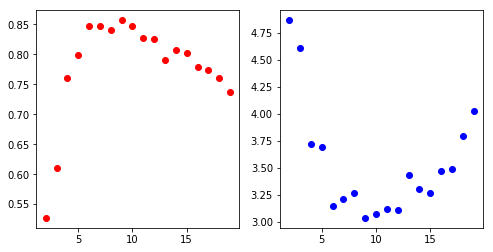

In [111]:

def fit_rf(x, y):
    x_train, x_test, y_train, y_test = train_test_split(x, y, 
                                                        test_size=0.2, 
                                                        random_state=231)    
     
    # 5. Declare data preprocessing steps
    pipeline = make_pipeline(preprocessing.StandardScaler(), 
                             RandomForestRegressor(n_estimators=100))

    # 6. Declare hyperparameters to tune
    hyperparameters = { 'randomforestregressor__max_features' : ['auto', 'sqrt', 'log2'],
                      'randomforestregressor__max_depth': [None, 5, 3, 1]}

    # 7. Tune model using cross-validation pipeline
    clf = GridSearchCV(pipeline, hyperparameters, cv=10)

    clf.fit(X_train, y_train)

    # 8. Refit on the entire training set
    # No additional code needed if clf.refit == True (default is True)

    # 9. Evaluate model pipeline on test data
    pred = clf.predict(X_test)
    print(r2_score(y_test, pred))
    print(mean_absolute_error(y_test, pred))
    plt.plot(y_test, pred)

#fit_rf(spectrum_n_chl, nitrogen)
    

In [99]:
print(n)

1


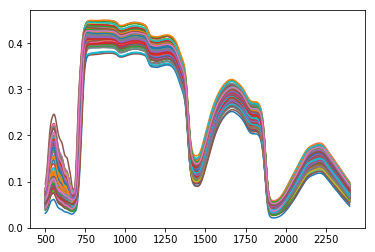

In [93]:
data_all.Wave_500
data.iloc[0:10, 7:1908]
plt.plot(np.linspace(500,2400, 1901), np.transpose(data.iloc[:, 7:1908]))
plt.show()

3

0.13694143848847457

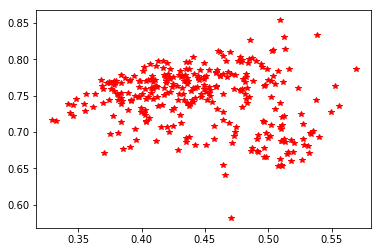

In [94]:
NDVI = (data_all.Wave_950 - data_all.Wave_660) / (data_all.Wave_950 + data_all.Wave_660)
CCI = (data_all.Wave_710 - data_all.Wave_660) / (data_all.Wave_710 + data_all.Wave_660)
plt.plot(CCI, NDVI, 'r*')
np.std(CCI/NDVI)/np.mean(CCI/NDVI)

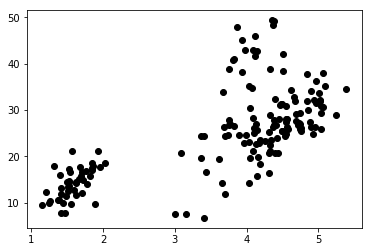

In [96]:
plt.plot(data_all.measured_percentN, data_all.Measured_Chl, 'ko')


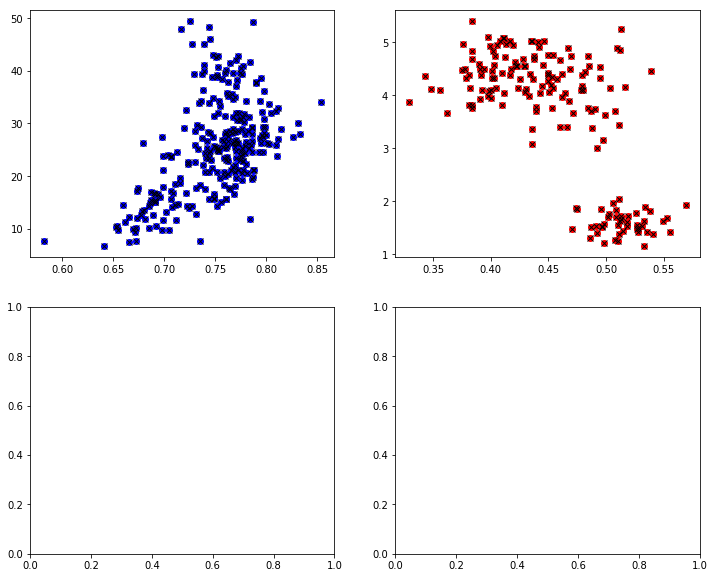

In [98]:
f, ax = plt.subplots(2,2, figsize = (12,10))
ax[0][0].plot(NDVI, data_all.Measured_Chl, 'bo')
ax[0][1].plot(CCI, data_all.measured_percentN, 'ro')
ax[0][0].plot(NDVI, data_all.Measured_Chl, 'kx')
ax[0][1].plot(CCI, data_all.measured_percentN, 'kx')

In [8]:
# 2. Import libraries and modules
import numpy as np
import pandas as pd
 
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.externals import joblib 
 
# 3. Load red wine data.
dataset_url = 'http://mlr.cs.umass.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv'
data = pd.read_csv(dataset_url, sep=';')
 
# 4. Split data into training and test sets
y = data.quality
X = data.drop('quality', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=23, 
                                                    stratify=y)
 
# 5. Declare data preprocessing steps
pipeline = make_pipeline(preprocessing.StandardScaler(), 
                         RandomForestRegressor(n_estimators=100))
 
# 6. Declare hyperparameters to tune
hyperparameters = { 'randomforestregressor__max_features' : ['auto', 'sqrt', 'log2'],
                  'randomforestregressor__max_depth': [None, 5, 3, 1]}
 
# 7. Tune model using cross-validation pipeline
clf = GridSearchCV(pipeline, hyperparameters, cv=10)
 
clf.fit(X_train, y_train)
 
# 8. Refit on the entire training set
# No additional code needed if clf.refit == True (default is True)
 
# 9. Evaluate model pipeline on test data
pred = clf.predict(X_test)
print(r2_score(y_test, pred))
print(mean_squared_error(y_test, pred))
 
# 10. Save model for future use
#joblib.dump(clf, 'rf_regressor.pkl')
# To load: clf2 = joblib.load('rf_regressor.pkl')


0.5067740177976876
0.318265625


Corr(X)
[[ 1.    0.45  0.01 -0.02]
 [ 0.45  1.    0.04  0.05]
 [ 0.01  0.04  1.    0.51]
 [-0.02  0.05  0.51  1.  ]]
Corr(Y)
[[ 1.    0.5  -0.03 -0.05]
 [ 0.5   1.   -0.1  -0.11]
 [-0.03 -0.1   1.    0.47]
 [-0.05 -0.11  0.47  1.  ]]


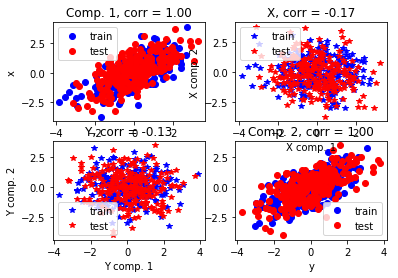

True B (such that: Y = XB + Err)
[[1 1 1]
 [2 2 2]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]]
Estimated B
[[ 1.1  1.   1. ]
 [ 2.   2.   2. ]
 [-0.  -0.  -0. ]
 [ 0.   0.  -0.1]
 [-0.  -0.   0. ]
 [ 0.   0.  -0. ]
 [-0.  -0.   0. ]
 [ 0.   0.  -0. ]
 [ 0.   0.   0. ]
 [-0.  -0.   0. ]]
R2 for all components (): 0.834
Mean absolute error is (): 0.789
[1.42930385 2.77437046 0.07761871 0.2463894  0.07165021 0.29096402
 0.11542812 0.29317034 0.05325434 0.03639128]
Estimated betas
[[ 1. ]
 [ 2. ]
 [ 0.1]
 [-0.1]
 [-0. ]
 [-0. ]
 [ 0.1]
 [-0.1]
 [-0. ]
 [-0.1]]


In [8]:
import numpy as np
import pylab as pl
from sklearn.cross_decomposition import PLSCanonical, PLSRegression, CCA
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error


def vip(model):
  t = model.x_scores_
  w = model.x_weights_
  q = model.y_loadings_
  p, h = w.shape
  vips = np.zeros((p,))
  s = np.diag(t.T @ t @ q.T @ q).reshape(h, -1)
  total_s = np.sum(s)
  for i in range(p):
      weight = np.array([ (w[i,j] / np.linalg.norm(w[:,j]))**2 for j in range(h) ])
      vips[i] = np.sqrt(p*(s.T @ weight)/total_s)
  return vips

###############################################################################
# Dataset based latent variables model

n = 500
# 2 latents vars:
l1 = np.random.normal(size=n)
l2 = np.random.normal(size=n)

latents = np.array([l1, l1, l2, l2]).T
X = latents + np.random.normal(size=4 * n).reshape((n, 4))
Y = latents + np.random.normal(size=4 * n).reshape((n, 4))

X_train = X[:int(n / 2)]
Y_train = Y[:int(n / 2)]
X_test = X[int(n / 2):]
Y_test = Y[int(n / 2):]

print("Corr(X)")
print(np.round(np.corrcoef(X.T), 2))
print("Corr(Y)")
print(np.round(np.corrcoef(Y.T), 2))

###############################################################################
# Canonical (symetric) PLS

# Transform data
# ~~~~~~~~~~~~~~
plsca = PLSCanonical(n_components=2)
plsca.fit(X_train, Y_train)
X_train_r, Y_train_r = plsca.transform(X_train, Y_train)
X_test_r, Y_test_r = plsca.transform(X_test, Y_test)

# Scatter plot of scores
# ~~~~~~~~~~~~~~~~~~~~~~
# 1) on diagonal plot X vs Y scores on each components
pl.subplot(221)
pl.plot(X_train_r[:, 0], Y_train_r[:, 0], "ob", label="train")
pl.plot(X_test_r[:, 0], Y_test_r[:, 0], "or", label="test")
pl.xlabel("y")
pl.ylabel("x")
pl.title('Comp. 1, corr = %.2f' %
         np.corrcoef(X_test_r[:, 0], X_test_r[:, 0])[0, 1])
pl.legend()

pl.subplot(224)
pl.plot(X_train_r[:, 1], Y_train_r[:, 1], "ob", label="train")
pl.plot(X_test_r[:, 1], Y_test_r[:, 1], "or", label="test")
pl.xlabel("y")
pl.ylabel("x")
pl.title('Comp. 2, corr = %.2f' %
         np.corrcoef(X_test_r[:, 1], X_test_r[:, 1])[0, 1])
pl.legend()

# 2) Off diagonal plot components 1 vs 2 for X and Y
pl.subplot(222)
pl.plot(X_train_r[:, 0], X_train_r[:, 1], "*b", label="train")
pl.plot(X_test_r[:, 0], X_test_r[:, 1], "*r", label="test")
pl.xlabel("X comp. 1")
pl.ylabel("X comp. 2")
pl.title('X, corr = %.2f' % np.corrcoef(X_test_r[:, 0], X_test_r[:, 1])[0, 1])
pl.legend()

pl.subplot(223)
pl.plot(Y_train_r[:, 0], Y_train_r[:, 1], "*b", label="train")
pl.plot(Y_test_r[:, 0], Y_test_r[:, 1], "*r", label="test")
pl.xlabel("Y comp. 1")
pl.ylabel("Y comp. 2")
pl.title('Y, corr = %.2f' % np.corrcoef(Y_test_r[:, 0], Y_test_r[:, 1])[0, 1])
pl.legend()
pl.show()

###############################################################################
# PLS regression, with multivariate response, a.k.a. PLS2

n = 1000
q = 3
p = 10
X = np.random.normal(size=n * p).reshape((n, p))
B = np.array([[1, 2] + [0] * (p - 2)] * q).T
# each Yj = 1*X1 + 2*X2 + noize
Y = np.dot(X, B) + np.random.normal(size=n * q).reshape((n, q)) + 5

pls2 = PLSRegression(n_components=3)
pls2.fit(X, Y)
print("True B (such that: Y = XB + Err)")
print(B)
# compare pls2.coefs with B
print("Estimated B")
print(np.round(pls2.coef_, 1))
pls2.predict(X)
print('R2 for all components (): %g' %round(r2_score(Y,pls2.predict(X)),3)) #Calcuted from PLSRegression's 'predict' function.
print('Mean absolute error is (): %g' %round(mean_absolute_error(Y,pls2.predict(X)),3))
print(vip(pls2))

###############################################################################
# PLS regression, with univariate response, a.k.a. PLS1

n = 1000
p = 10
X = np.random.normal(size=n * p).reshape((n, p))
y = X[:, 0] + 2 * X[:, 1] + np.random.normal(size=n * 1) + 5
pls1 = PLSRegression(n_components=3)
pls1.fit(X, y)
# note that the number of compements exceeds 1 (the dimension of y)
print("Estimated betas")
print(np.round(pls1.coef_, 1))

###############################################################################
# CCA (PLS mode B with symetric deflation)

cca = CCA(n_components=2)
cca.fit(X_train, Y_train)
X_train_r, Y_train_r = plsca.transform(X_train, Y_train)
X_test_r, Y_test_r = plsca.transform(X_test, Y_test)


In [41]:
Y.shape

(1000, 3)

In [33]:
print (sklearn.__version__)


0.20.2


In [23]:
n/2

250.0

In [29]:
np.random.normal(size=4 * n).reshape((n, 4)).shape

(1000, 4)